# CDDP Tutorial (HCW)

This tutorial runs a simple example of the constrained differential dynamic programming algorithm on spacecraft linear relative motion control problem.

In [ ]:
# If needed, run the following lines:
using Pkg
Pkg.precompile()

In [40]:
using Plots; gr(legend=true,dpi=800); 
using LinearAlgebra
using BenchmarkTools
using DifferentialEquations
using Random
using Distributions
using Printf
using Revise
using CDDP

## Define the Dynamics Model

In [41]:
includet("../src/models/hcw.jl")
model = HCW()
nx, nu = model.dims.nx, model.dims.nu
;

## Define Problem Horizon and Steps

In [42]:
tf = 5000.0
tN = 500
dt = (tf - 0.0)/tN;

## Define the Cost Function

In [43]:
function ell_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    Q = zeros(6, 6)
    R = Diagonal(1e+1*[1; 1; 1])
    return 0.5 * transpose(x - x_ref) * Q * (x - x_ref) + 0.5 * transpose(u) * R * u
end

function phi_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+1 * [1; 1; 1]])
    return 0.5 * transpose(x - x_final) * Qf * (x - x_final)
end
;

## Define the boundary conditions

In [44]:
x_init = model.x_init
x_final = model.x_final;

Initial trajectory

In [46]:
X0, U0 = initialize_trajectory(model, tf, tN, x_init, model.f!);

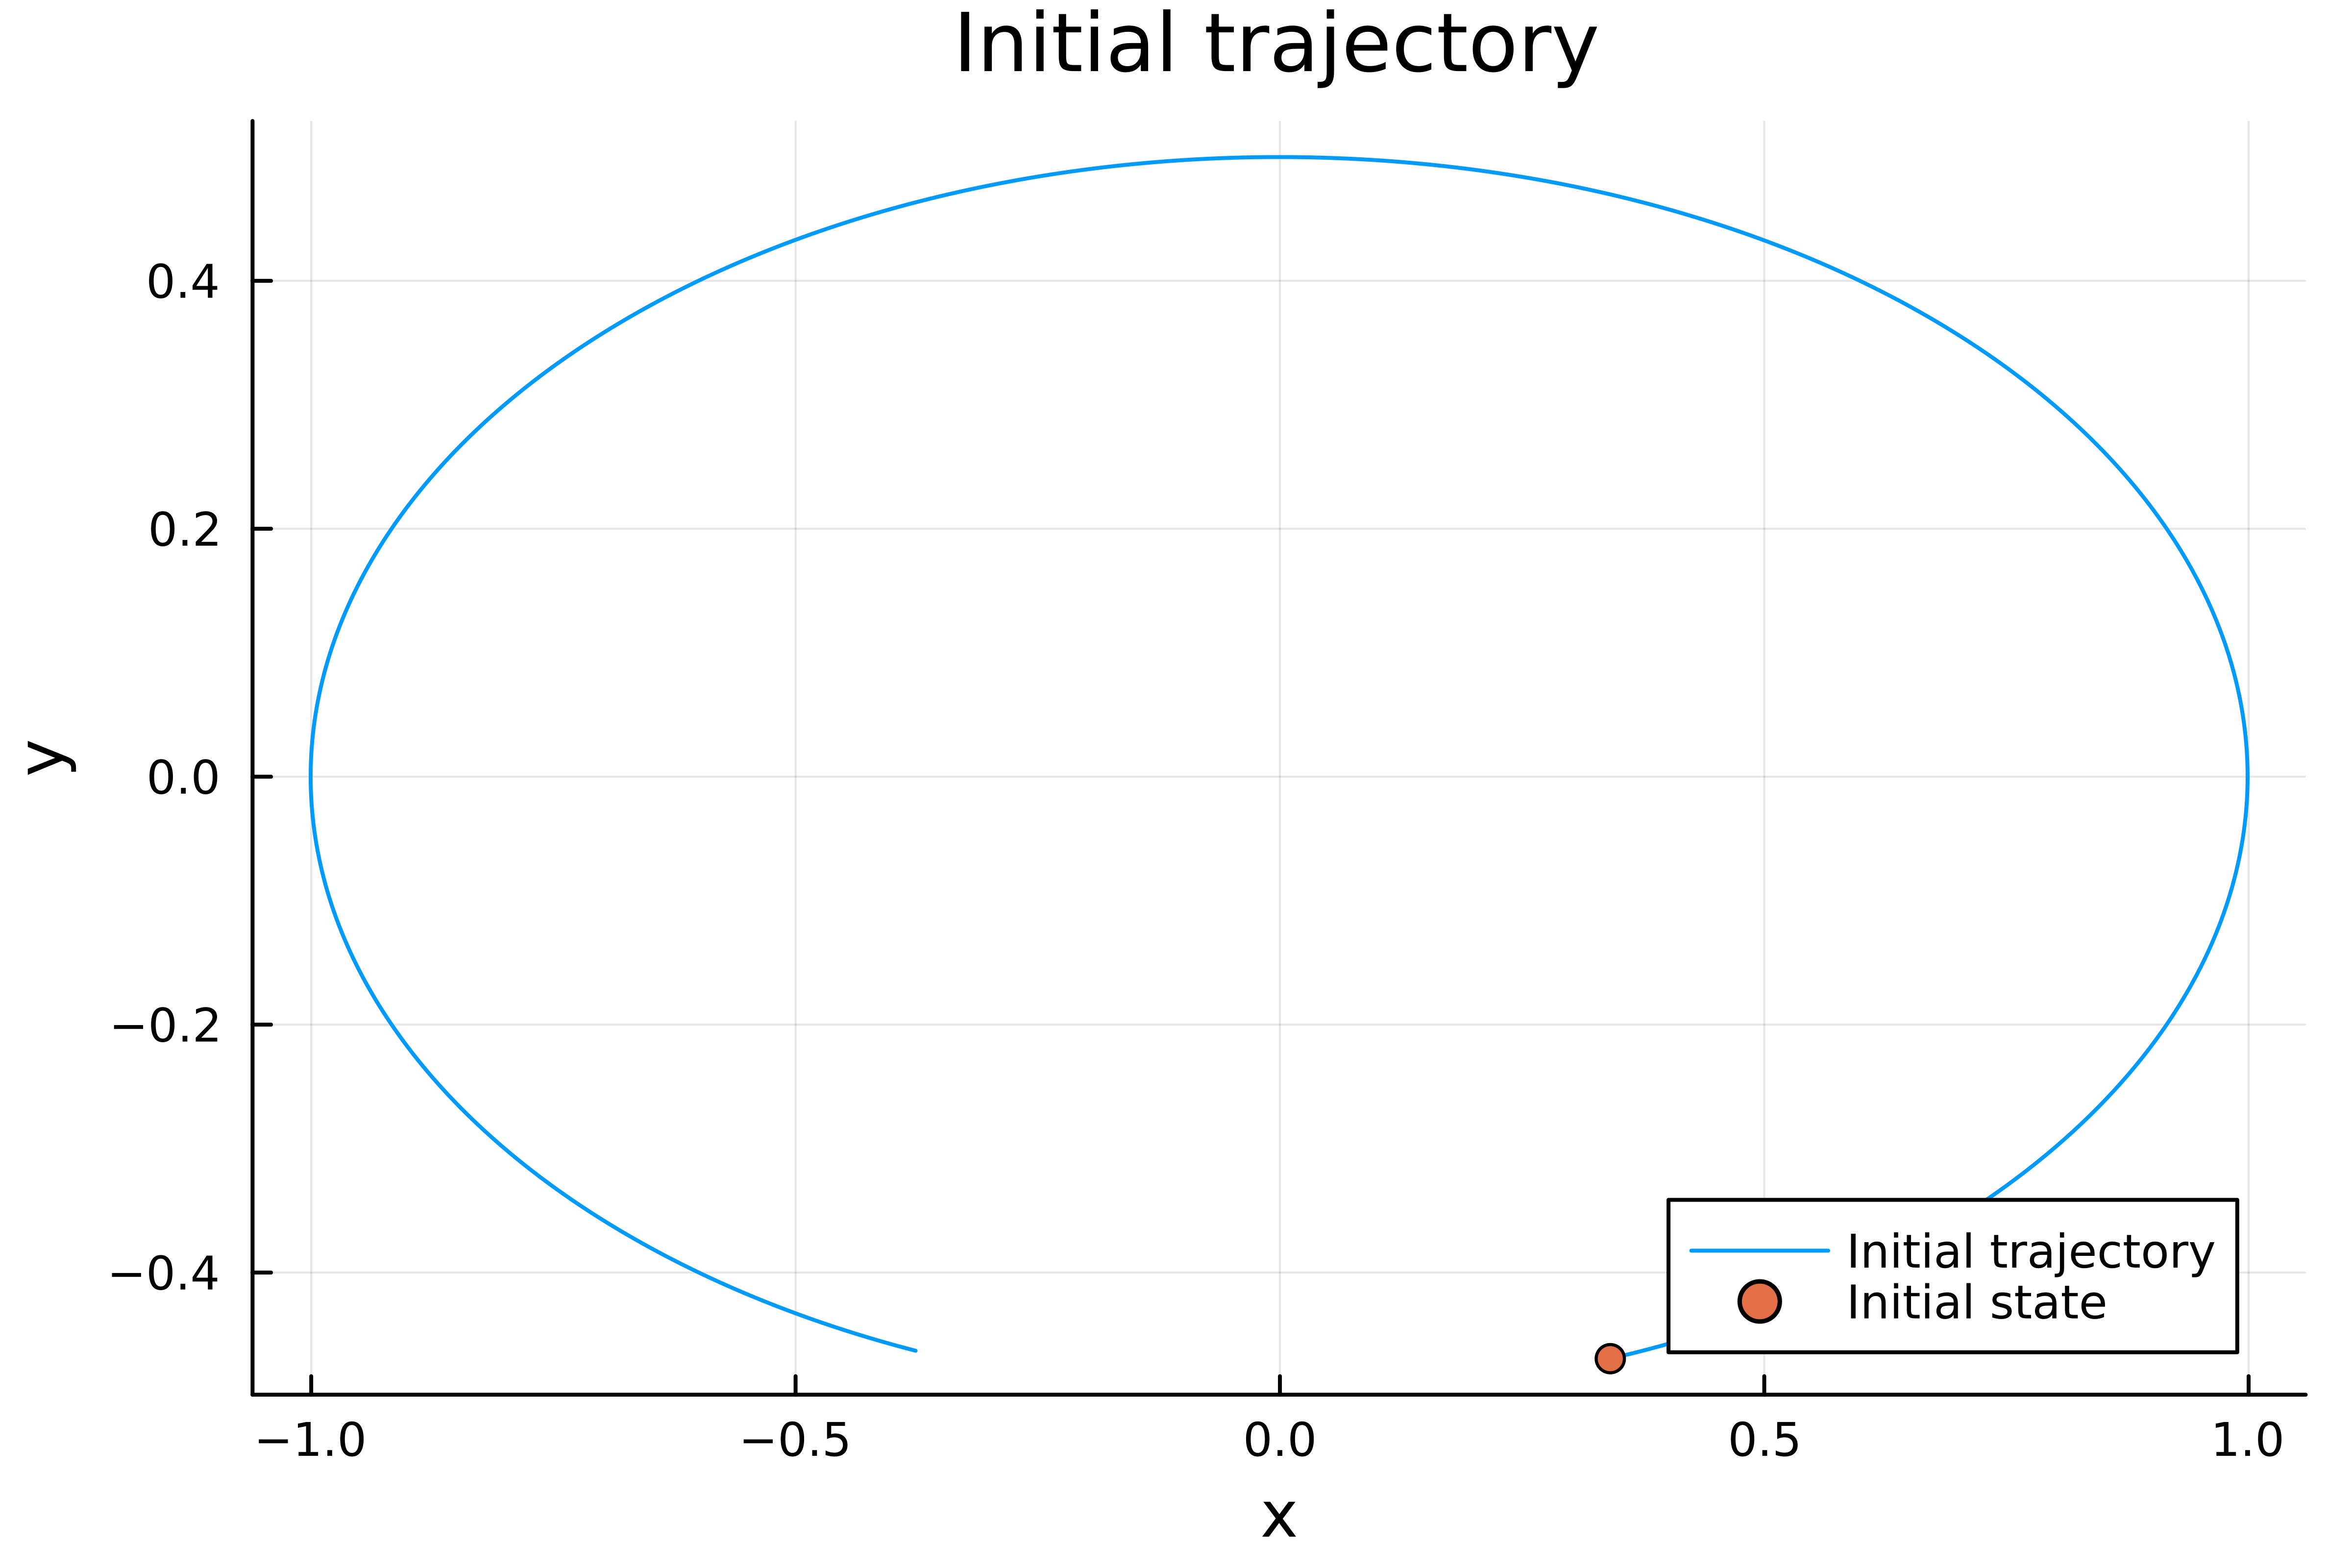

In [47]:
plot(X0[2,:], X0[1,:], label="Initial trajectory", xlabel="x", ylabel="y", title="Initial trajectory", legend=:bottomright)
scatter!((x_init[2], x_init[1]), label="Initial state")

## Construct the Problem

In [18]:
prob = iLQRProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    x_dim=x_dim, 
    u_dim=u_dim, 
    ell=ell_cost, 
    ϕ=phi_cost, 
    f=model.f, 
    ∇f=empty, 
    x_init=x_init, 
    x_final=x_final, 
    X_ref=nothing
);

## Solve iLQR Problem

In [12]:
sol = solve_ilqr(
    prob, 
    X=nothing, 
    U=nothing, 
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30))
    
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start iLQR Problem Solver 
**************************************************************************************
iter    objective 
                


0       20.297458,  
                
1       0.014755,  
                


2       0.003238,  
                
3       0.000667,  
                


4       0.000098,  
                
5       0.000023,  
                


6       0.000019,  
                
7       0.000019,  
                


8       0.000019,  
                
9       0.000019,  
                


**************************************************************************************
>>> Successfully Finished iLQR Problem Solver <<< 
**************************************************************************************


## Plot Trajectory

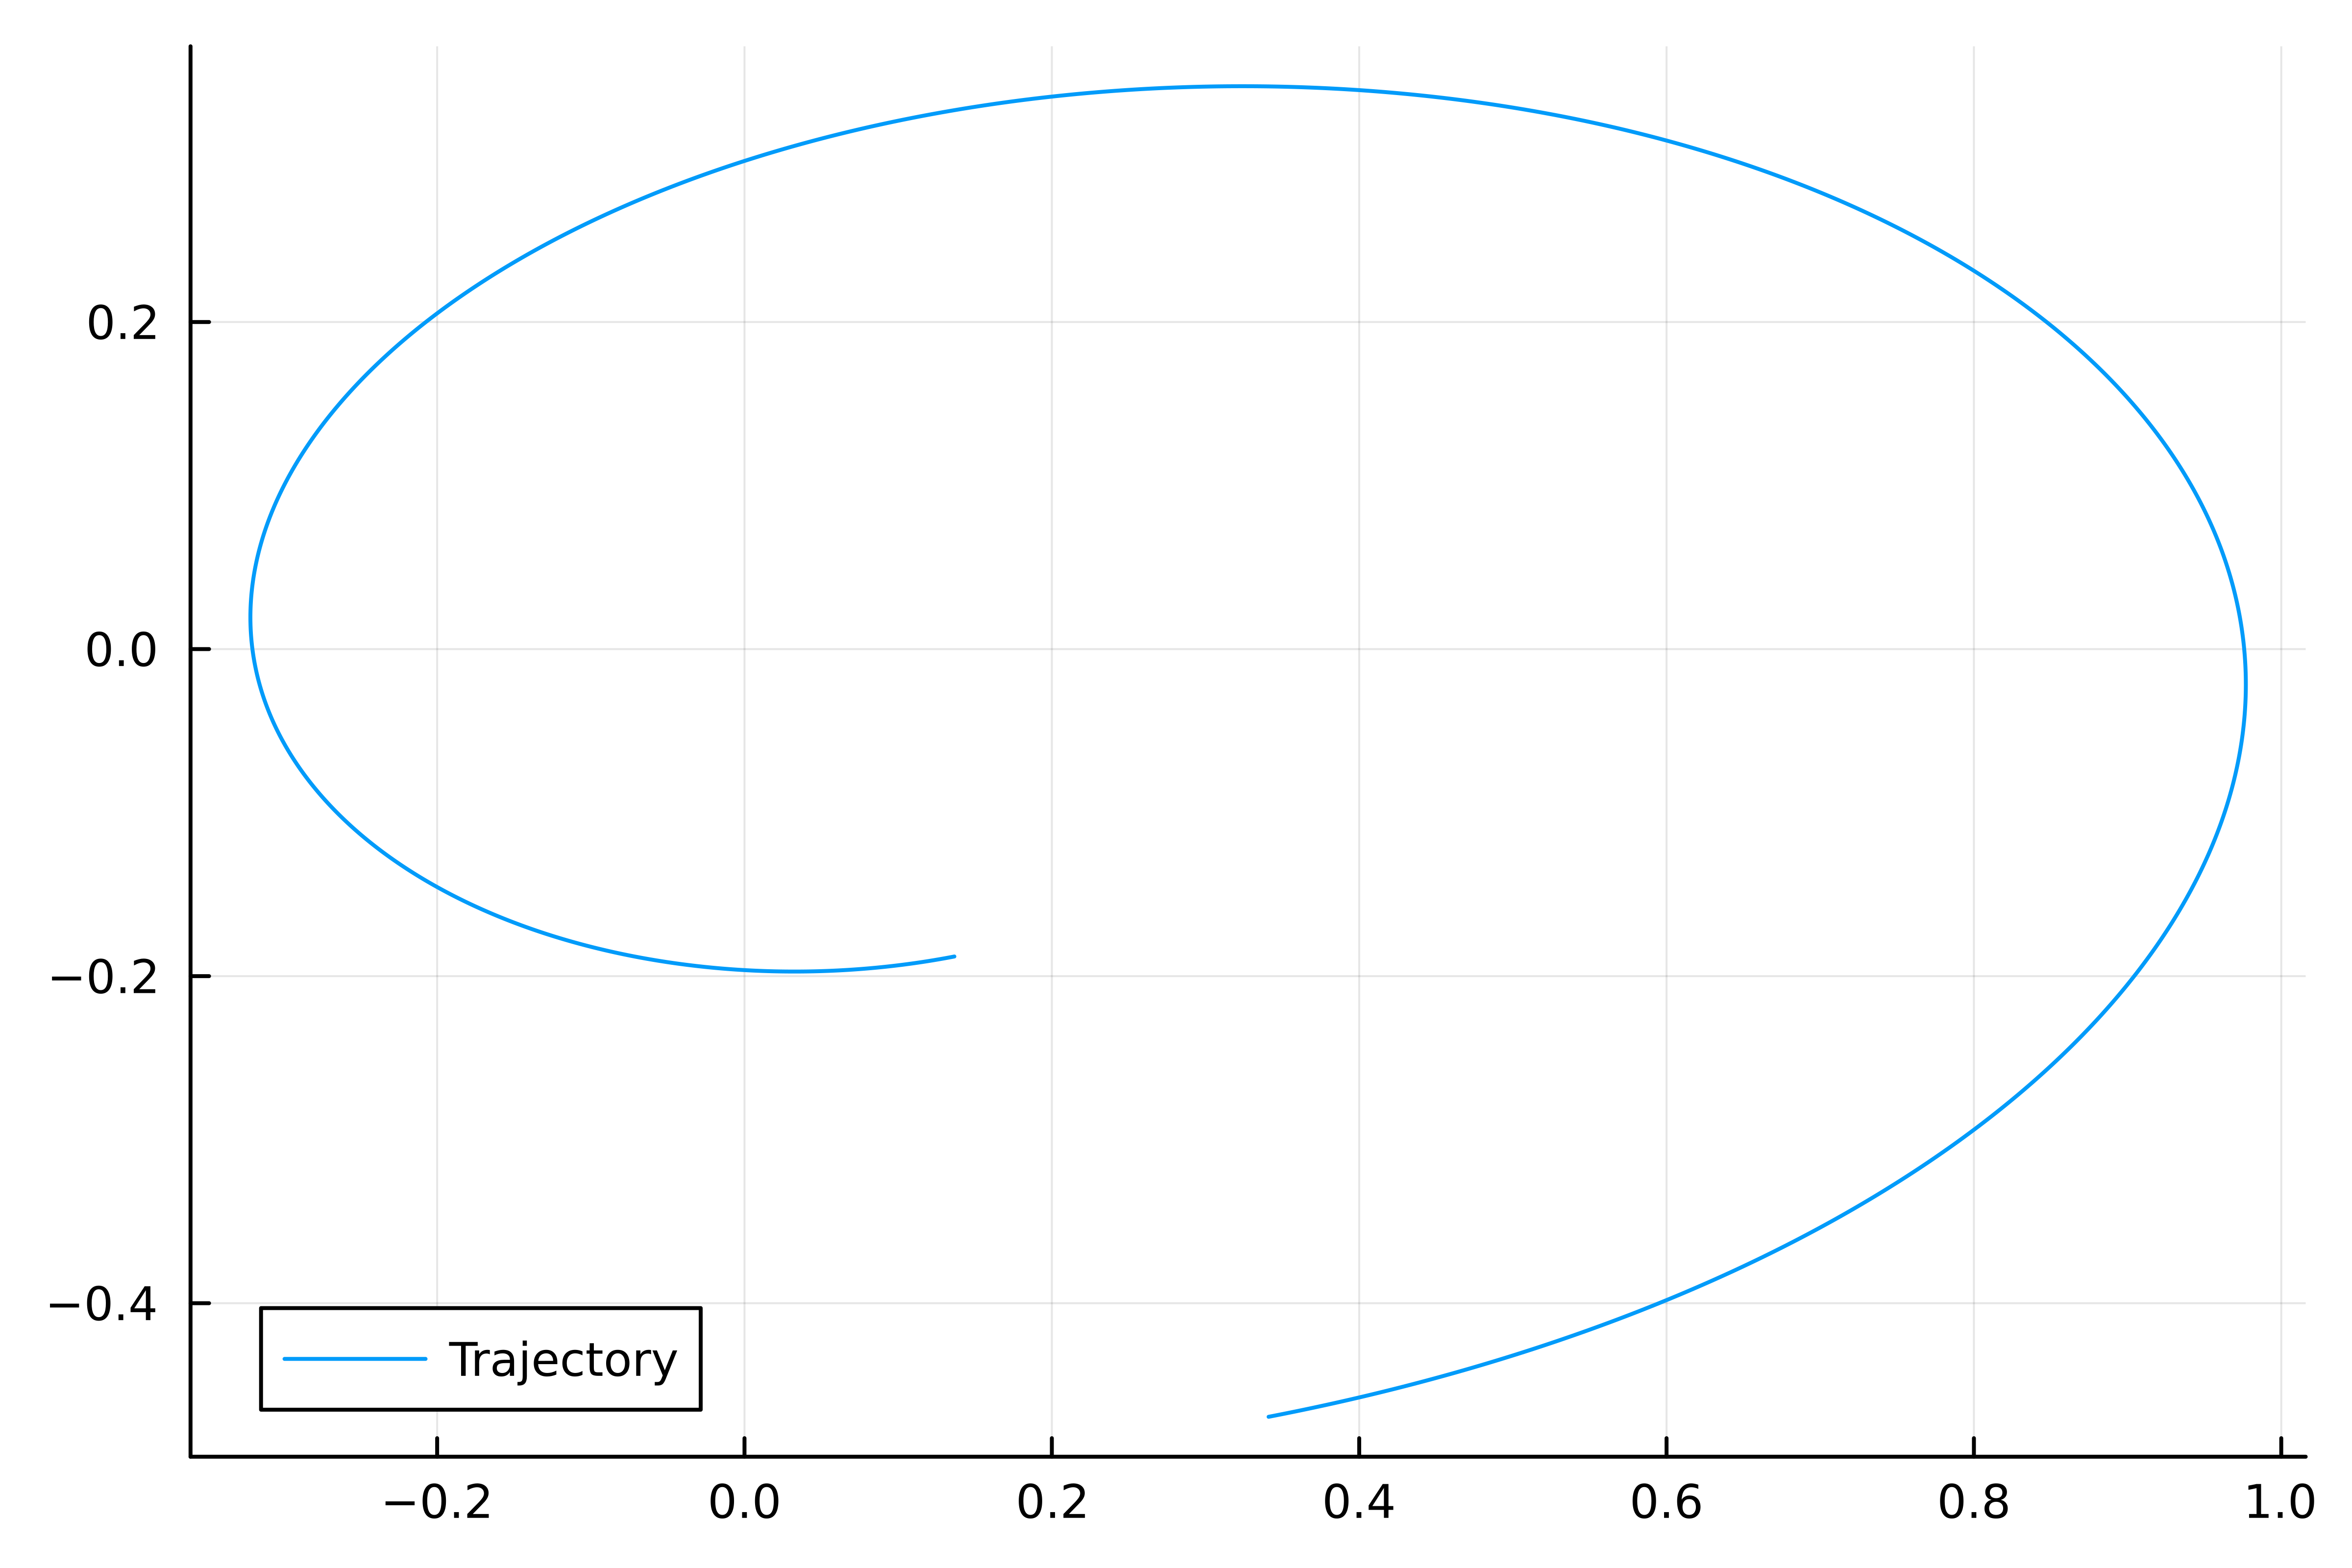

In [13]:
plot(X[2,:],X[1,:],label="Trajectory")

In [20]:
function c_inst(
    x::Vector,
    u::Vector,
)
    x0 = [45; 135]
    r_scale = 200

    return [
        1e-0 * (20 / r_scale - norm(x[1:2] - x0 / r_scale))
        1e-0 * (10 / r_scale - norm(x[1:2]))
    ]
end
λ_dim = 2

2

In [23]:
prob = CDDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    x_dim=x_dim, 
    u_dim=u_dim, 
    λ_dim=λ_dim,
    ell=ell_cost, 
    ϕ=phi_cost, 
    f=model.f, 
    ∇f=empty, 
    x_init=x_init, 
    x_final=x_final,
    c=c_inst,
    c_final=empty, 
    X_ref=nothing
)
;


In [53]:
sol = solve_cddp(
    prob, 
    X=nothing, 
    U=nothing, 
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30),
    μip=1e-8,
    μip_lb=1e-12,
)

# sol = solve_cddp(
#     prob, reg_param1=1e-4,reg_param2=1e-4,μip=1e-8,max_ite=10); 
# sol = solve_cddp(prob, X=X_ilqr, U=U_ilqr, reg_param1=1e-4,reg_param2=1e-4,μip=1e-8,max_ite=10); 
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_cddp, U_cddp, J_cddp, gains_cddp = sol.X, sol.U, sol.J, sol.gains;

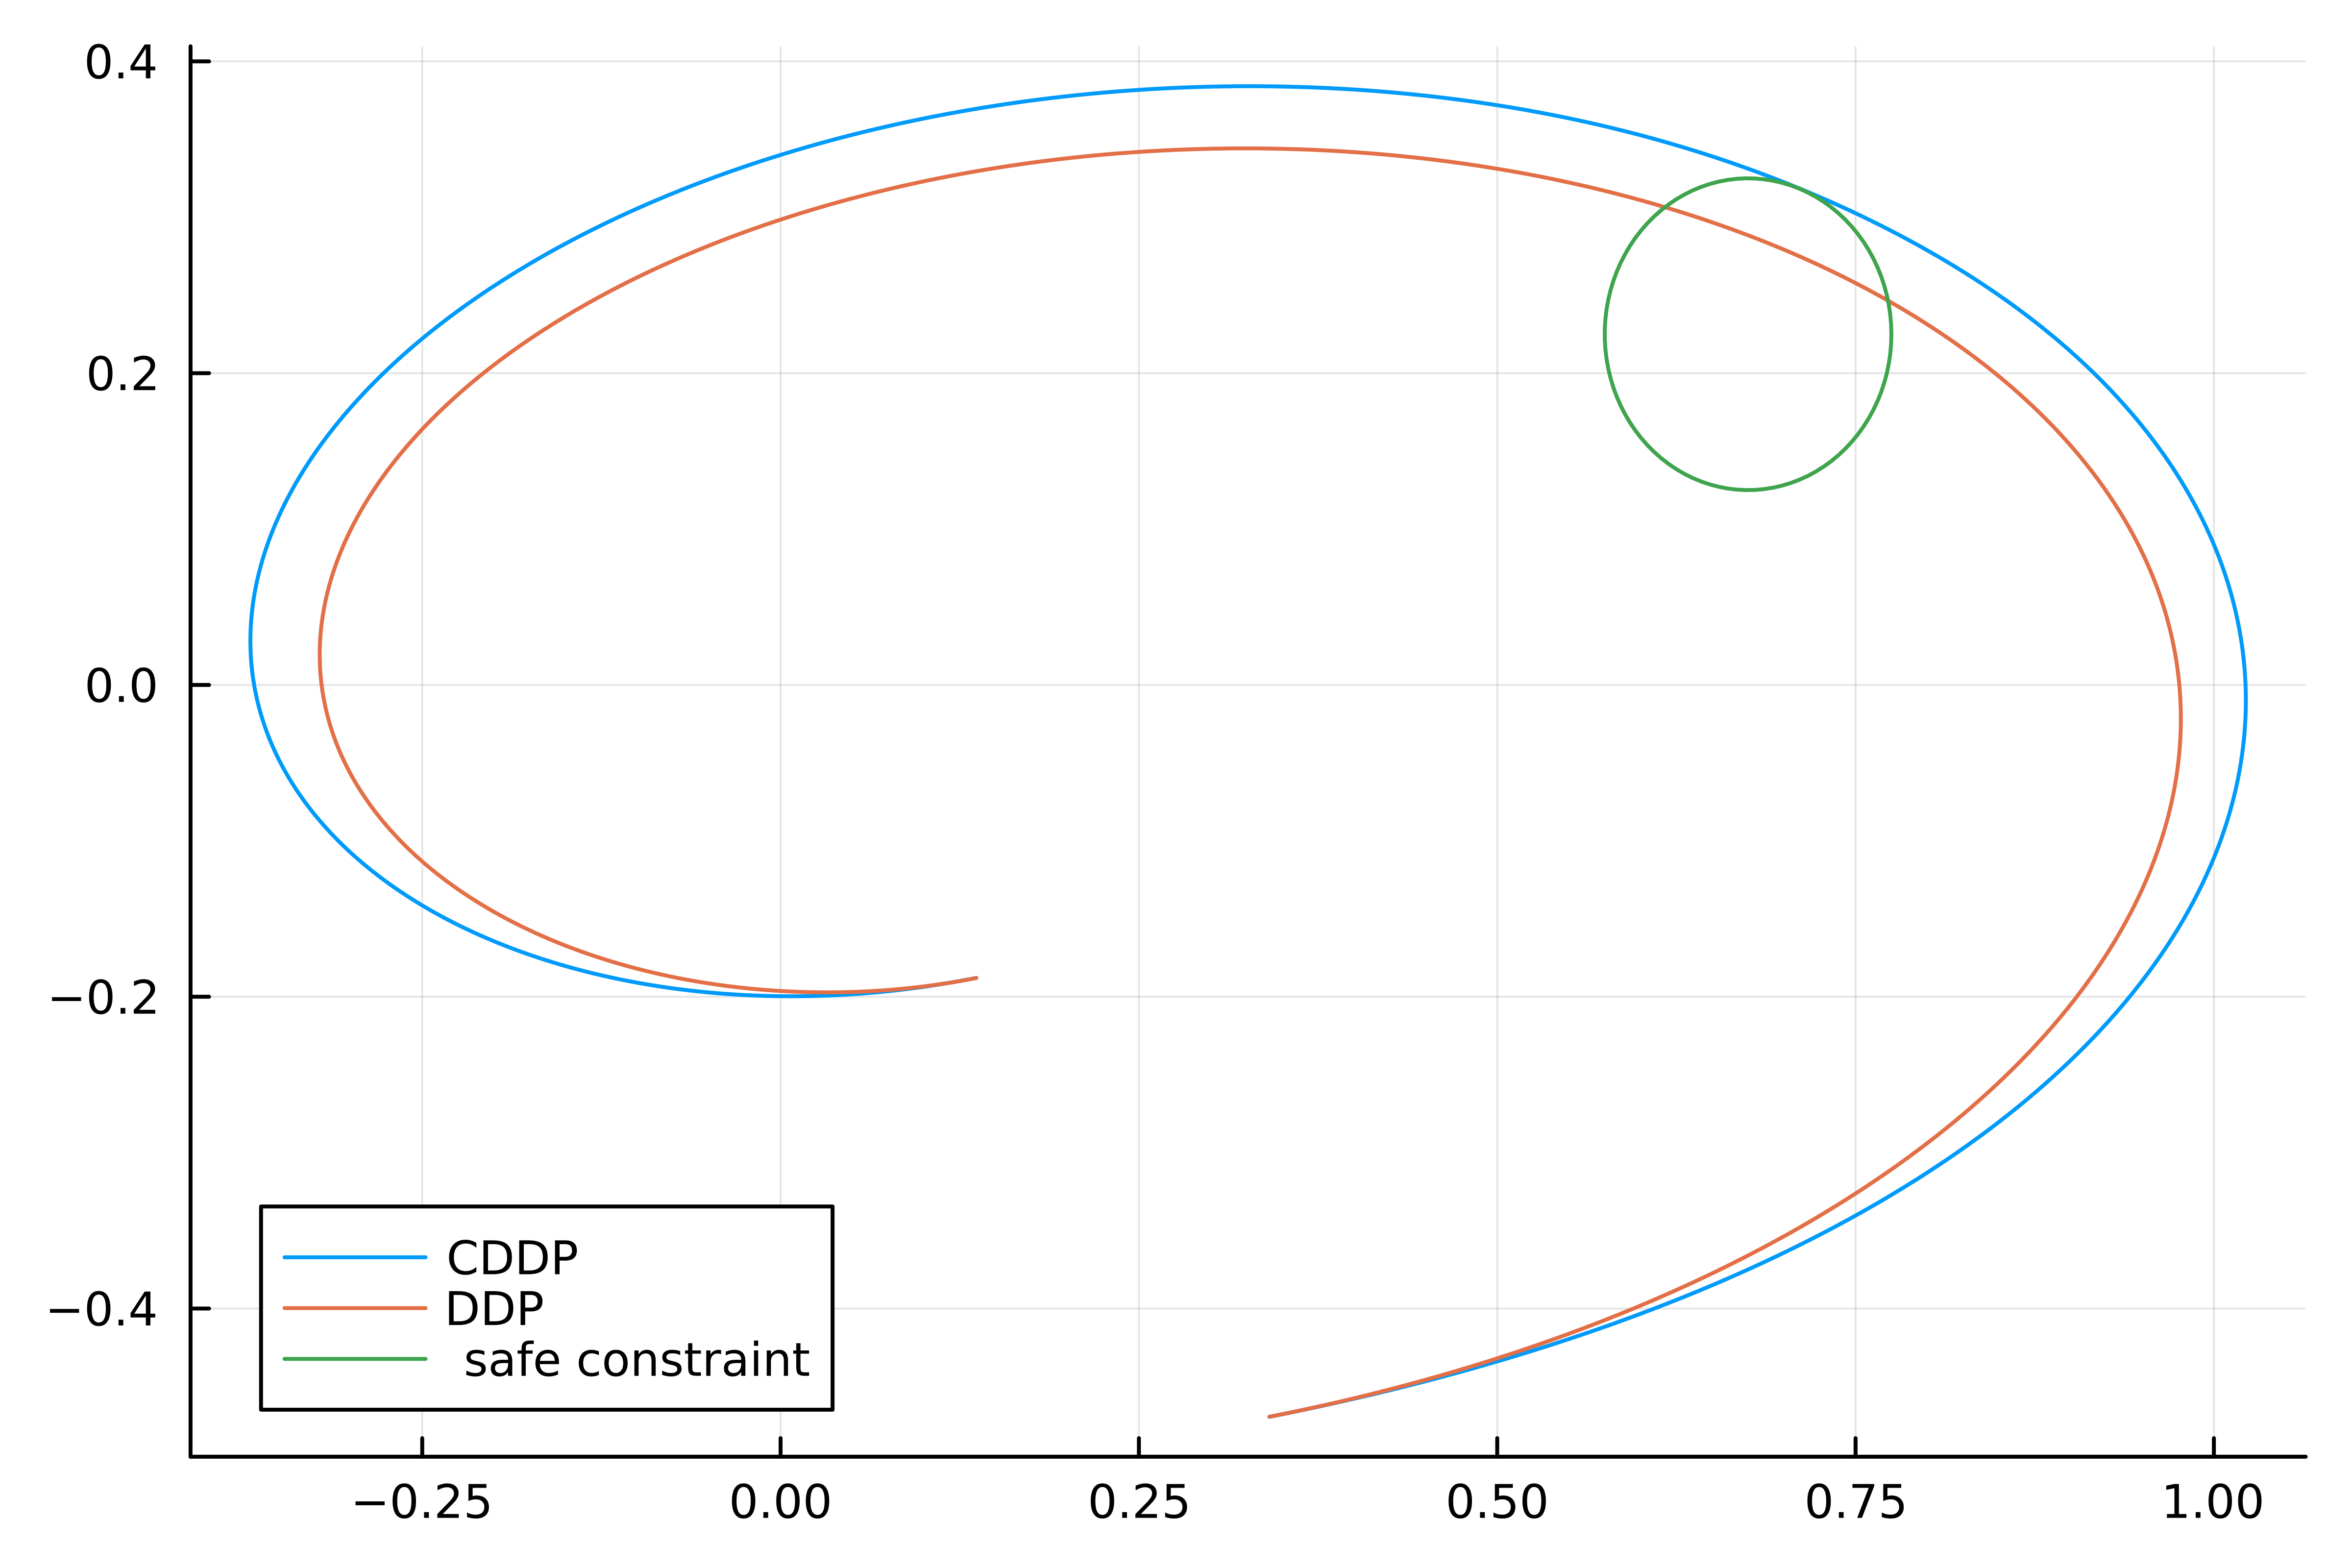

In [54]:
t = LinRange(0,pi,100)
x = zeros(size(t,1))
y = zeros(size(t,1))
for k = 1:size(t,1)
    x[k] = (20*sin(2*t[k]) + 45) / 200
    y[k] = (20*cos(2*t[k]) + 135) / 200
end

plot(X_cddp[2,:], X_cddp[1,:], label="CDDP")
plot!(X_ilqr[2,:], X_ilqr[1,:], label="DDP")
plot!(y,x,color=:auto,label=" safe constraint",linewidth=1)
# plot(X[2,:],X[1,:],label="CDDP")
# plot!(X_ilqr[2,:],X_ilqr[1,:],label="ilqr")

## Two-body Problem

In [144]:
includet("../src/models/TwoBody.jl")
model = TwoBody()
x_dim, u_dim = model.x_dim, model.u_dim
;


In [145]:
tf = 8.162395951775
tN = 500
dt = (tf - 0.0)/tN
;

In [146]:
X0, U0 = initialize_trajectory(model)
plot(X0[2,:],X0[1,:],label="Initial Trajectory")

ErrorException: type TwoBody has no field r_scale

In [137]:
function ell_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    Q = zeros(6, 6)
    R = Diagonal(1e+2*[1; 1; 1])
    return transpose(x - x_ref) * Q * (x - x_ref) + transpose(u) * R * u
end

function phi_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+1 * [1; 1; 1]])
    return transpose(x - x_final) * Qf * (x - x_final)
end
;

In [138]:
x_init = model.x_init
x_final = model.x_final;

In [139]:
prob = iLQRProblem(model, tf, tN, dt, x_dim, u_dim, ell_cost, phi_cost, model.f!, x_init, x_final, nothing)
sol = solve_ilqr(prob)
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start iLQR Problem Solver 
**************************************************************************************


ErrorException: type TwoBody has no field r_scale

In [4]:
hN = 50; # horizon length
Ts = 10.0; # sampling time
Tsc = 10.0; # sampling time for control

In [15]:
Random.seed!(1234)

TaskLocalRNG()

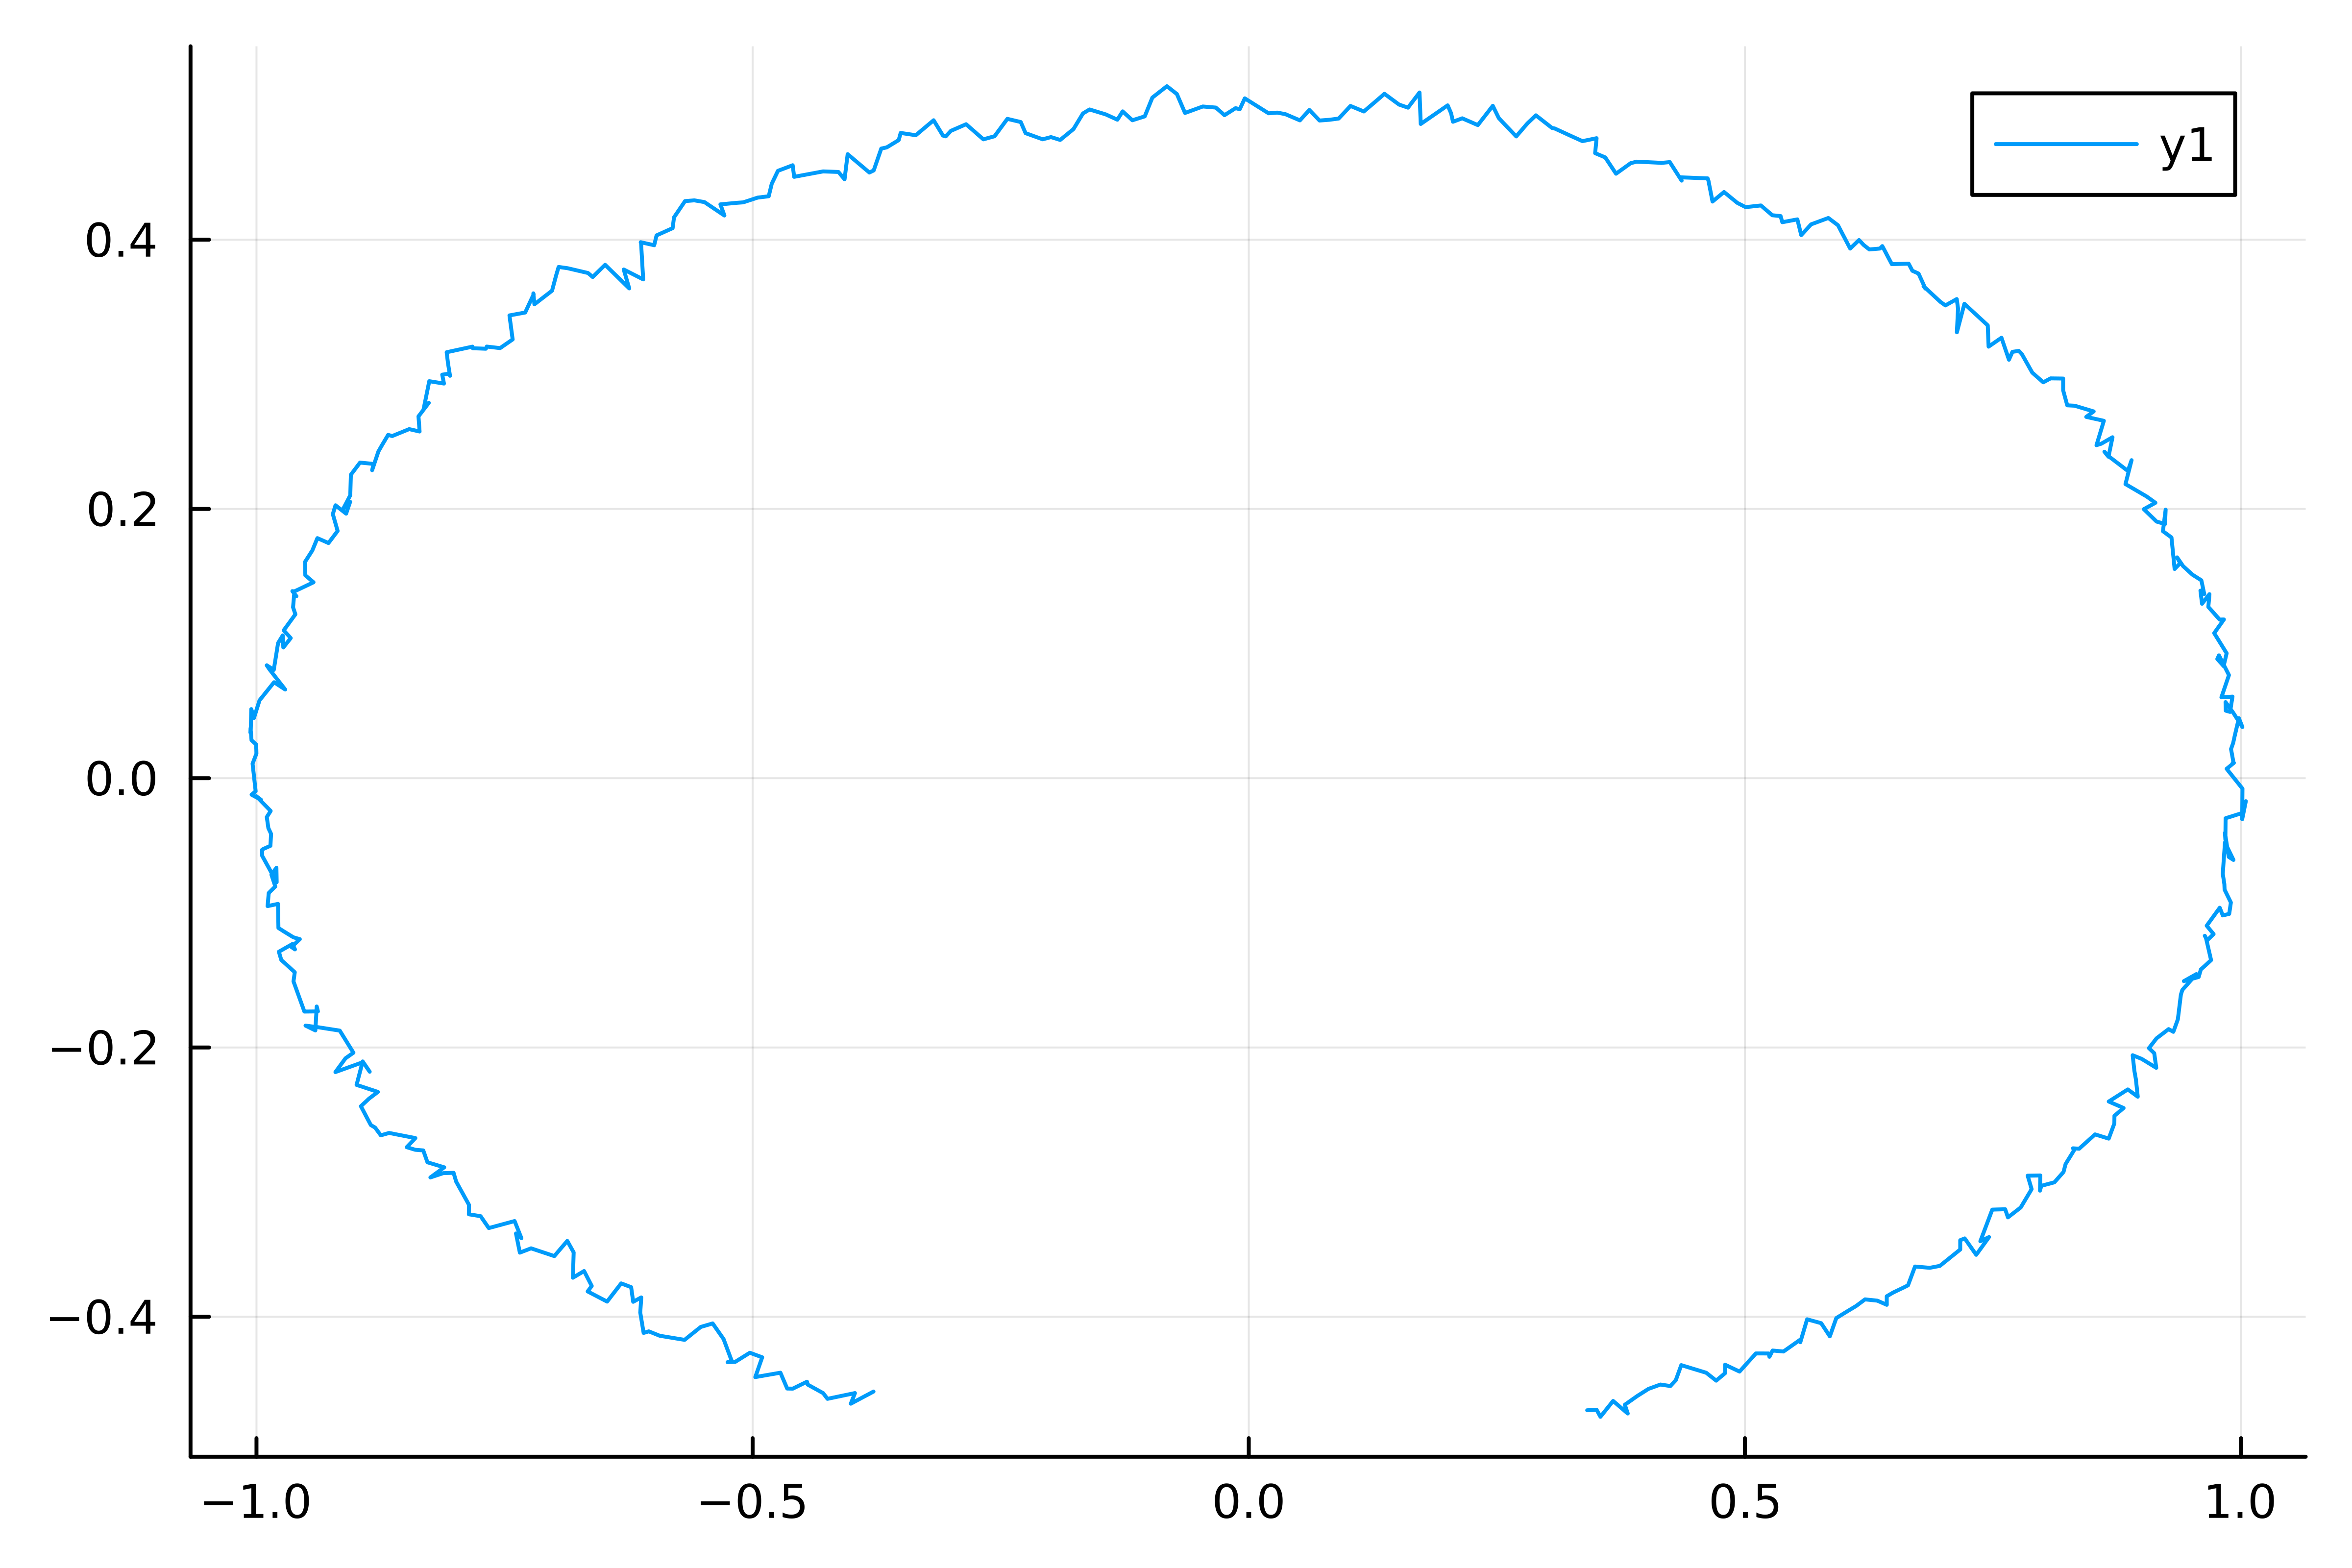

In [59]:
hN = 50
# includet("../src/filter.jl")
XEst = zeros(nx, tN+1)
XTrue = zeros(nx, tN+1)
X_sol = zeros(nx, tN+1)
U_sol = zeros(nu, tN)

xEst = model.x_init
xTrue = model.x_init
PEst = 1e-0 * Matrix{Float64}(I(nx))
PEst_arr = zeros(nx, nx, tN+1)
PEst_arr[:,:,1] = PEst

XTrue[:,1] = xTrue
XEst[:,1] = xEst
X_sol[:,1] = xEst

u_out = zeros(nu)
U = zeros(nu, hN)

params_arr = model.params.arr
dyn_funcs = MPPIDynamicsFunction(f=model.f, f! =model.f!)

μ_proc = zeros(model.dims.nw)
# Σ_proc = 1e-10 * Diagonal(ones(model.dims.nw, model.dims.nw))
μ_meas = zeros(model.dims.nv)
# Σ_meas = 1e-10* Diagonal(ones(model.dims.nv, model.dims.nv))

Σ_proc = Diagonal(1e-0 * ones(model.dims.nw))
Σ_meas = Diagonal(1e-0 * ones(model.dims.nv))
dist_proc = MvNormal(μ_proc, Σ_proc)
dist_meas = MvNormal(μ_meas, Σ_meas)

ekf_prob = EKFProblem(
    dt,
    model.dims,
    dyn_funcs.f,
    model.h,
    μ_proc,
    μ_meas,
    Σ_proc,
    Σ_meas,
)

# MPPI simulations
for j in 1:tN 
    t = (j-1) * dt

    # if mod(t, Tsc) == 0
    # else
    #     problem.x_init = X_sol[:, j]
    #     problem.x_final = X_ddp[:, j+hN]
    #     problem.X_ref = X_ddp[:, j:j+hN]
    #     problem.U_md = Œ[:,j:j+hN]
        
    #     u_out, U = solve_mppi(problem, U=U, K=K, λ=λ, μ=μ, Σ=Σ, verbose=false)
    # end
    

    # if j+hN <= tN
    #     problem.x_final = X_ddp[:, j+hN]
    # else
    
        
    # end

    

    # solve optimal control problem
    # sol = solve_cddp(prob,max_ite=20, verbose=false);

    # simulate true dynamics
    p = ODEParameter(params=params_arr, U_ref=zeros(3))
    ode_prob =  ODEProblem(dyn_funcs.f, XTrue[:,j], (0.0,dt), p)
    X_ode = solve(ode_prob, Tsit5())
    XTrue[:,j+1] = X_ode.u[end]

    # take measurements
    # z = model.h(XTrue[:,j], zeros(3)) + vec(rand(dist_meas, 1))
    # z = model.h(XTrue[:,j], zeros(3)) + diagm(0.01*ones(3)).^2 * randn(3)
    z = model.h(XTrue[:,j], zeros(3)) + diagm(0.1*ones(3)).^2 * randn(3)

    dx_noise = vec(rand(dist_proc, 1))
    u_noised =  diagm(0.0001*ones(model.dims.nu)).^2 * randn(model.dims.nu)
    # u_noised = zeros(3)

    # solve EKF
    # XEst_, PEst_ = solve_EKF(model, ekf_prob, XEst[:,j]+dx_noise, u_out, PEst_arr[:,:,j], z, t=t, u_md=Œ(t))
    XEst_, PEst_ = solve_EKF(model, ekf_prob, XEst[:,j], u_noised, PEst_arr[:,:,j], z, t=t)
    
    XEst[:,j+1] = copy(XEst_)
    PEst_arr[:,:,j+1] = copy(PEst_)
    X_sol[:, j+1] = copy(XEst_)
    U_sol[:, j] = u_out
end

plot(XTrue[2,:],XTrue[1,:])
plot(X_sol[2,:], X_sol[1,:])
# plot!(XTrue[2,:],XTrue[1,:])
# scatter!((XEst[2,1],XEst[1,1]))